In [1]:
from math import pi
import numpy as np
import imageio as im
import matplotlib.pyplot as plt

###### Parameters ######
center_point = np.array([0.5,0])
FOV = [2, 2]
theta = 0
height = 800
width = 1600
#########################

img = im.imread('/home/vinamra/Desktop/equirectangular-toolbox/images/cube2.jpg')
frame = img
frame_height = frame.shape[0]
frame_width = frame.shape[1]
frame_channel = frame.shape[2]
cubeFaceHeight = frame_height/3
cubeFaceWidth = frame_width/4

PI = pi
PI_2 = pi * 0.5
PI2 = pi * 2.0

In [2]:
xx, yy = np.meshgrid(np.linspace(0, 1, width), np.linspace(0, 1, height))
screen_points = np.array([xx.ravel(), yy.ravel()]).T

In [3]:
cp1 = center_point * 2 - 1
cp2 = np.array([PI, PI_2])
cp = cp1 * cp2 # point-wise multiplication

In [4]:
cc1 = (screen_points * 2 - 1) 
cc2 = np.array([PI, PI_2]) * (np.ones(screen_points.shape) * FOV)
convertedScreenCoord  = cc1 * cc2
# applying rotation
rot_cc_x = np.cos(theta*PI/180)*convertedScreenCoord.T[0] - np.sin(theta*PI/180)*convertedScreenCoord.T[1]
rot_cc_y = np.sin(theta*PI/180)*convertedScreenCoord.T[0] + np.cos(theta*PI/180)*convertedScreenCoord.T[1]

convertedScreenCoord.T[0]  = rot_cc_x
convertedScreenCoord.T[1]  = rot_cc_y
# equispaced angular points

In [5]:
# x and y co-ordinates
x = convertedScreenCoord.T[0]
y = convertedScreenCoord.T[1]

rou = np.sqrt(x ** 2 + y ** 2)
c = np.arctan(rou)
sin_c = np.sin(c)
cos_c = np.cos(c)

lat = np.arcsin(cos_c * np.sin(cp[1]) + (y * sin_c * np.cos(cp[1])) / rou)
lon = cp[0] + np.arctan2(x * sin_c, rou * np.cos(cp[1]) * cos_c - y * np.sin(cp[1]) * sin_c)
lat = (lat / PI_2 + 1.) * 0.5
lon = (lon / PI + 1.) * 0.5
spericalCoord = np.array([lon, lat]).T

screen_coord = spericalCoord
uf = np.mod(screen_coord.T[0],1)
vf = screen_coord.T[1]
theta = vf * PI
phi = uf * PI2

In [6]:
# Convert to Cubemap index
xxx = np.sin(phi) * np.sin(theta) * -1
yyy = np.cos(theta) * -1
zzz = np.cos(phi) * np.sin(theta) * -1

# normalize this
a = np.maximum(np.absolute(zzz),np.maximum(np.absolute(xxx),np.absolute(yyy)))

#Vector Parallel to the unit vector that lies on one of the cube faces
xa = np.divide(xxx, a) 
ya = np.divide(yyy, a)
za = np.divide(zzz, a)

xPixel = np.zeros((xa.size))
yPixel = np.zeros((xa.size))
xOffset = np.zeros((xa.size))
yOffset = np.zeros((xa.size))

#vec = np.column_stack((xa,ya,za))
for ii in xrange(xa.size):
    if int(xa[ii]) == 1:
        #Right
        xPixel[ii] = (((za[ii] + 1) / 2) - 1) * cubeFaceWidth
        xOffset[ii] = 2 * cubeFaceWidth
        yPixel[ii] = (((ya[ii] + 1) / 2)) * cubeFaceHeight
        yOffset[ii] = cubeFaceHeight
    elif int(xa[ii]) == -1:
        #Left
        xPixel[ii] = (((za[ii] + 1) / 2)) * cubeFaceWidth
        xOffset[ii] = 0
        yPixel[ii] = (((ya[ii] + 1) / 2)) * cubeFaceHeight
        yOffset[ii] = cubeFaceHeight
    elif int(ya[ii]) == 1:
        #Up
        xPixel[ii] = (((xa[ii] + 1) / 2)) * cubeFaceWidth
        xOffset[ii] = cubeFaceWidth
        yPixel[ii] = (((za[ii] + 1) / 2) - 1) * cubeFaceHeight
        yOffset[ii] = 2 * cubeFaceHeight
    elif int(ya[ii]) == -1:
        #Down
        xPixel[ii] = (((xa[ii] + 1) / 2)) * cubeFaceWidth
        xOffset[ii] = cubeFaceWidth
        yPixel[ii] = (((za[ii] + 1) / 2)) * cubeFaceHeight
        yOffset[ii] = 0
    elif int(za[ii]) == 1:
        #Front
        xPixel[ii] = (((xa[ii] + 1) / 2)) * cubeFaceWidth
        xOffset[ii] = cubeFaceWidth
        yPixel[ii] = (((ya[ii] + 1) / 2)) * cubeFaceHeight
        yOffset[ii] = cubeFaceHeight
    elif int(za[ii]) == -1:
        #Back
        xPixel[ii] = (((xa[ii] + 1) / 2) - 1) * cubeFaceWidth
        xOffset[ii] = 3 * cubeFaceWidth
        yPixel[ii] = (((ya[ii] + 1) / 2)) * cubeFaceHeight
        yOffset[ii] = cubeFaceHeight
    
xPixel = np.absolute(xPixel)
yPixel = np.absolute(yPixel)    
xPixel = np.add(xPixel,xOffset)
yPixel = np.add(yPixel,yOffset)
xPixel = np.rint(xPixel).astype(int)
yPixel = np.rint(yPixel).astype(int)

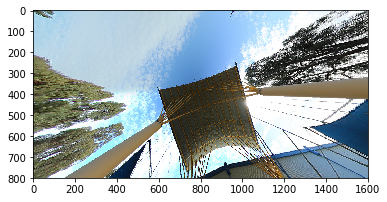

In [7]:
base_y0 = np.multiply(yPixel, frame_width) #frame is a combined cubemap
pix_cor = np.add(base_y0, xPixel)
flat_img = np.reshape(frame, [-1, frame_channel])
A = np.take(flat_img, pix_cor, axis=0)

nfov = np.reshape(np.round(A).astype(np.uint8), [height, width, 3])
plt.imshow(nfov)
plt.show()
plt.imsave('/home/vinamra/Desktop/equirectangular-toolbox/images/morningout5.png',nfov)